In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
%matplotlib inline


In [2]:
#######################
## Define line class ##
#######################
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False 
        
        # x values of the last 10 fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last 10 iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last 10 iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        self.difflr = [np.array([False])]
        
        #polynomial coefficients of the last 10 fits of the line
        self.last10_fit = [] 
        self.last10_bestfit = []
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
        
        #Inverse Perspective Transformation Matrix
        self.Minv = None
        
        #src points for perspetive transform
        self.srcp = None
        
        self.status = 'bad'
        
        self.temp = []

    #check the current fit is valid or not
    def goodfit(self):
        coef0 = (self.diffs[0] < 5e-4)
        coef1 = (self.diffs[1] < 5e-1) 
        coef2 = (self.diffs[2] < 5e1)
        
        if (coef0) and (coef1) and (coef2):
            #print("Good!")
            self.status = 'good'
            return True
        else:
            #print("Bad!")
            self.status = 'bad'
            return False

    #update the best fit
    def update_bestfit(self):
        if len(self.last10_fit) < 8:
            self.detected = True
            self.last10_fit.append(self.current_fit)
            self.best_fit = np.sum(self.last10_fit, axis=0)/(len(self.last10_fit))
            #print("Less")
        else:
            if self.goodfit():
                self.last10_fit.pop(0)
                self.last10_fit.append(self.current_fit)
                self.best_fit = np.sum(self.last10_fit, axis=0)/8
     
    def update_allx(self):
        if  self.detected:
            self.allx = self.best_fit[0]*self.ally**2 + self.best_fit[1]*self.ally + self.best_fit[2] 
    
    def update_radius(self):
        ym_per_pix = 30/720 
        xm_per_pix = 3.7/700 
        
        y_eval = self.ally[-1]
        fit = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)
        self.radius_of_curvature = ((1 + (2*fit[0]*y_eval*ym_per_pix + fit[1])**2)**1.5) / np.absolute(2*fit[0])

    def update_diffs(self):
        if self.detected:
            self.diffs[0] = np.abs(self.best_fit[0]-self.current_fit[0])
            self.diffs[1] = np.abs(self.best_fit[1]-self.current_fit[1])
            self.diffs[2] = np.abs(self.best_fit[2]-self.current_fit[2]) 
        
    def update(self): 
        self.temp.append((self.current_fit, self.best_fit))
        self.update_diffs()
        self.update_bestfit()
        self.update_allx()
        if self.detected:
            self.update_radius()
    
        

In [3]:
#############################################
## prepare object points and image porints ##
#############################################
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

#Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

#Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

#Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [4]:
#############################
## Calculate camera matrix ##
#############################
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
image = cv2.undistort(img, mtx, dist, None, mtx)

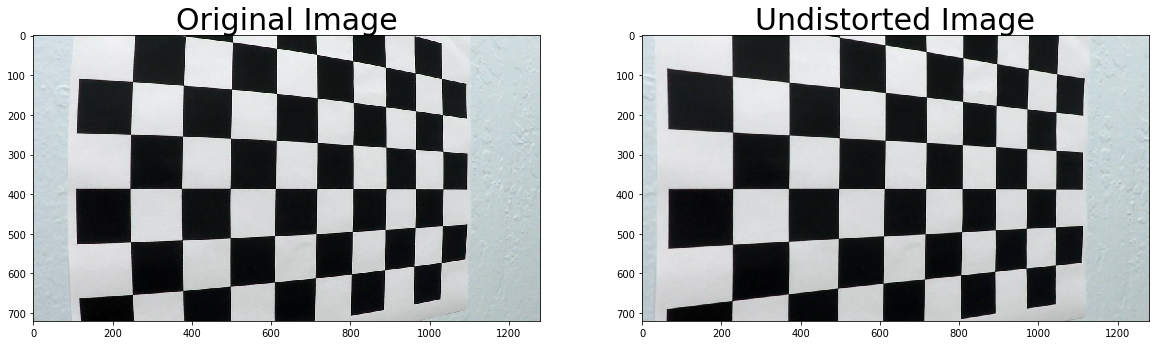

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

In [6]:
######################################
## Define color threshold functions ##
######################################
def hls_thres(img, thresh=(0, 255), channel = 2):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,channel]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

def lab_thres(img, thresh=(0, 255), channel = 2):
    
    lab = cv2.cvtColor(np.copy(img), cv2.COLOR_RGB2LAB)
    channel = lab[:,:,channel]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

In [7]:
#########################################
## Define gradient threshold fucntions ##
#########################################
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    direction = np.arctan2(sobely, sobelx)
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    sobel = np.uint8(255 * sobel / np.max(sobel))
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel >= mag_thresh[0]) & (sobel <= mag_thresh[1])] = 1
    return binary_output

def combined_grad_thres(img, dir_thres, mag_thres, gx_thres, gy_thres):
    
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=dir_thres)
    mag_binary = mag_thresh(img, sobel_kernel=5, mag_thresh=mag_thres)
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, mag_thresh=gx_thres)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, mag_thresh=gy_thres)

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

In [8]:
########################################
## define image thresholding function ##
########################################
def thresholding(image):
    hls_s = hls_thres(image, thresh=(90,255), channel=2)
    hls_h = hls_thres(image, thresh=(20,120), channel=0)  
    lab_l = lab_thres(image, thresh=(160, 255), channel=0)
    lab_b = lab_thres(image, thresh=(0, 120), channel=2)
    grad = combined_grad_thres(image, 
                               dir_thres=(0.8,1.2), 
                               mag_thres=(20,100), 
                               gx_thres=(20,100), 
                               gy_thres=(20,100))
    combined = np.zeros_like(hls_s)
    combined[((hls_h == 1) & (hls_s == 1)) | ((grad == 1) & ((lab_l == 1) | (lab_b == 1))) ] = 1
    return combined

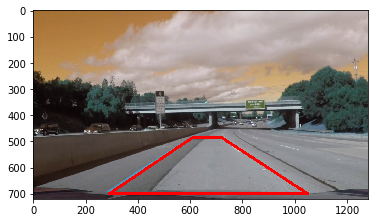

In [9]:
####################################
## perspective transform choosing ##
####################################
ptrans = cv2.imread('test_images/test12.jpg')
cv2.line(ptrans,(560+50, 485), (770-50, 485), color=(255,0,0), thickness = 10)
cv2.line(ptrans,(1100-50, 700), (240+50, 700), color=(255,0,0), thickness = 10)
cv2.line(ptrans,(560+50, 485), (240+50, 700), color=(255,0,0), thickness = 10)
cv2.line(ptrans,(1100-50, 700), (770-50, 485), color=(255,0,0), thickness = 10)

plt.imshow(ptrans[0:720,0:1280,:])

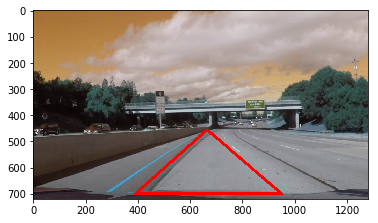

In [10]:
################
## Mask Test1 ##
################
mask_test1 = cv2.imread('test_images/test12.jpg')
cv2.line(mask_test1,(660, 460), (670, 460), color=(255,0,0), thickness = 10)
cv2.line(mask_test1,(950, 700), (390, 700), color=(255,0,0), thickness = 10)
cv2.line(mask_test1,(660, 460), (390, 700), color=(255,0,0), thickness = 10)
cv2.line(mask_test1,(950, 700), (670, 460), color=(255,0,0), thickness = 10)

plt.imshow(mask_test1[0:720,0:1280,:])

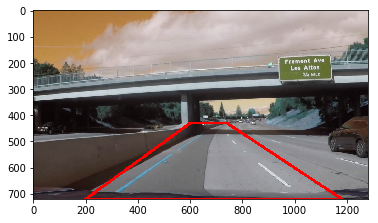

In [11]:
################
## Mask Test3 ##
################
mask_test2 = cv2.imread('test_images/test10.jpg')
cv2.line(mask_test2,(550+50, 430), (740, 430), color=(255,0,0), thickness = 10)
cv2.line(mask_test2,(1180, 720), (200, 720), color=(255,0,0), thickness = 10)
cv2.line(mask_test2,(550+50, 430), (200, 720), color=(255,0,0), thickness = 10)
cv2.line(mask_test2,(1180, 720), (740, 430), color=(255,0,0), thickness = 10)

plt.imshow(mask_test2[0:720,0:1280,:])

In [12]:
#######################################
## Define perspective transformation ##
#######################################
def img_warp(img, mtx, dist, src, dst):
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, Minv
    

In [13]:
###############################
## define region of interest ##
###############################
def img_mask(image):
    result = np.zeros_like(image)
    result[:,200:600] = image[:,200:600]
    result[:,700:1100] = image[:,700:1100]
    return result

In [14]:
############################################
## Define sliding window search functions ##
############################################

# Used when no fit is found or lane fitting is lost
def sws_initial(binary_warped, flag, nonzero):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2.5):,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    if flag:
        base = np.argmax(histogram[midpoint:]) + midpoint
    else:
        base = np.argmax(histogram[:midpoint])
    
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    current = base
    margin = 50
    minpix = 50
    lane_inds = []
    
    for window in range(nwindows):

        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_x_low = current - margin
        win_x_high = current + margin
                    
        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
        
        # Append these indices to the lists
        lane_inds.append(good_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_inds) > minpix:
            current = np.int(np.mean(nonzerox[good_inds]))

    # Concatenate the arrays of indices
    lane_inds = np.concatenate(lane_inds)
    return lane_inds

# Used when lane fitting is found
def sws_continue(binary_warped, Lane):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 20
    fit = Lane.best_fit
    
    # Use the current best fit to find the lane indices
    lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + 
    fit[2] - margin)) & (nonzerox < (fit[0]*(nonzeroy**2) + 
    fit[1]*nonzeroy + fit[2] + margin)))
    
    return lane_inds


In [15]:
###########################################
## Define sliding window search function ##
###########################################

# Mostly used Udacity's practice codes
def sws1(binary_warped, rLane, lLane, debug=1):

    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(binary_warped.shape[0]/2)
    histogram_l = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:midpoint], axis=0)
    histogram_r = np.sum(binary_warped[int(binary_warped.shape[0]/2):,midpoint:], axis=0)

    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if rLane.detected and lLane.detected:
        left_lane_inds = []
        right_lane_inds = []
        margin = 50
        right = rLane.best_fit
        left = lLane.best_fit
        
        left_lane_inds = ((nonzerox > (left[0]*(nonzeroy**2) + left[1]*nonzeroy + 
        left[2] - margin)) & (nonzerox < (left[0]*(nonzeroy**2) + 
        left[1]*nonzeroy + left[2] + margin))) 

        right_lane_inds = ((nonzerox > (right[0]*(nonzeroy**2) + right[1]*nonzeroy + 
        right[2] - margin)) & (nonzerox < (right[0]*(nonzeroy**2) + 
        right[1]*nonzeroy + right[2] + margin)))  
        
    else:
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):

            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
        
            if debug:
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (255,0,0), 5) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (255,0,0), 5) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
    
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial and update Lane instances
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    #print(left_fit)
    #print(right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    
    lLane.ally = ploty
    lLane.current_fit = left_fit
    lLane.update()
    left = lLane.best_fit
    
    rLane.ally = ploty
    rLane.current_fit = right_fit
    rLane.update()
    right = rLane.best_fit
    
    left_fitx = left[0]*ploty**2 + left[1]*ploty + left[2]
    right_fitx = right[0]*ploty**2 + right[1]*ploty + right[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fitx, right_fitx, ploty

# Used the "initial" and "continue" functions defined above
def sws2(binary_warped, rLane, lLane):

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Identify nonzero lane pixel
    if rLane.detected:
        right_lane_inds = sws_continue(binary_warped, rLane)
    else:
        right_lane_inds = sws_initial(binary_warped, 1, nonzero)
    
    if lLane.detected:
        left_lane_inds = sws_continue(binary_warped, lLane)
    else:
        left_lane_inds = sws_initial(binary_warped, 0, nonzero)
        
    # Extract left and right line pixel positions
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial and update Lane instances
    if (len(leftx) > 0):
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = lLane.best_fit
        
    if (len(rightx) > 0):
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = rLane.best_fit

    
    # Generate x and y values for plotting and update moving average status
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    difflr = left_fit-right_fit
    
    lLane.ally = ploty
    lLane.current_fit = left_fit
    lLane.difflr = difflr
    lLane.update()
    left = lLane.best_fit
    
    rLane.ally = ploty
    rLane.current_fit = right_fit
    lLane.difflr = difflr
    rLane.update()
    right = rLane.best_fit
    
    left_fitx = left[0]*ploty**2 + left[1]*ploty + left[2]
    right_fitx = right[0]*ploty**2 + right[1]*ploty + right[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fitx, right_fitx, ploty

In [16]:
##################################
## Define the pipeline function ##
##################################
def process_image(image_test, rLane, lLane, debug=0):
    
    # Undistort image
    undist = cv2.undistort(np.copy(image_test), mtx, dist)
    image_test = cv2.cvtColor(np.copy(image_test), cv2.COLOR_RGB2BGR)
    
    # Perform thresholding
    pipeline_result = thresholding(np.copy(image_test))

    # Perform masking
    mask_out = np.zeros_like(pipeline_result)  
    mask_in = np.ones_like(pipeline_result)  
    out_color = 1 
    in_color = 0
    vertices_out = np.array([[(150,680),
                              (550, 430), 
                              (740, 430), 
                              (1180,680)]], dtype=np.int32)
    
    vertices_in = np.array([[(390, 680),
                             (660, 500), 
                             (670, 500), 
                             (950, 680)]], dtype=np.int32)    
    
    cv2.fillPoly(mask_out, vertices_out, out_color)
    cv2.fillPoly(mask_in, vertices_in, in_color)
    
    masked = cv2.bitwise_and(pipeline_result, mask_out)
    masked = cv2.bitwise_and(masked, mask_in)
    
    
    # Perform perspective transform
    src = np.float32([[560, 485],
                      [770, 485],
                      [1100, 700],
                      [240, 700]])
    dst = np.float32([[300, 250],
                      [1000, 250],
                      [1000, 700],
                      [300, 700]])
    img_warp_result, Minv = img_warp(np.copy(masked), mtx, dist, src, dst)
    rLane.Minv = Minv
    lLane.Minv = Minv

    # Perform sliding window search
    #sws_out, left_fitx, right_fitx, ploty = sws1(img_warp_result, rLane, lLane, debug)
    sws_out, left_fitx, right_fitx, ploty = sws2(np.copy(img_warp_result), rLane, lLane)
    
    # Create an image to draw the lines on
    warped = masked
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(np.copy(color_warp), Minv, (image_test.shape[1], image_test.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
    # Print some data
    xm_per_pix = 3.7/700
    dev = (left_fitx[-1] + right_fitx[-1] - image_test.shape[1]) / 2 * xm_per_pix
    font = cv2.FONT_HERSHEY_SIMPLEX
    T1 = 'Left Radius: ' + str(lLane.radius_of_curvature)
    T2 = 'Right Radius: ' + str(rLane.radius_of_curvature)
    T3 = 'diffc[0]: ' + str(float("{0:.4f}".format(abs(lLane.best_fit[0] - rLane.best_fit[0]))))
    T4 = 'diffc[1]: ' + str(float("{0:.4f}".format(abs(lLane.best_fit[1] - rLane.best_fit[1]))))
    
    T5 = 'curr: ' + str(float("{0:.4f}".format(lLane.current_fit[0]))) + ' '\
                   + str(float("{0:.4f}".format(lLane.current_fit[1]))) + ' '\
                   + str(float("{0:.4f}".format(lLane.current_fit[2])))
            
    T6 = 'best: ' + str(float("{0:.4f}".format(lLane.best_fit[0]))) + ' '\
                   + str(float("{0:.4f}".format(lLane.best_fit[1]))) + ' '\
                   + str(float("{0:.4f}".format(lLane.best_fit[2])))
            
    T7 = 'curr: ' + str(float("{0:.4f}".format(rLane.current_fit[0]))) + ' '\
                   + str(float("{0:.4f}".format(rLane.current_fit[1]))) + ' '\
                   + str(float("{0:.4f}".format(rLane.current_fit[2])))
            
    T8 = 'best: ' + str(float("{0:.4f}".format(rLane.best_fit[0]))) + ' '\
                   + str(float("{0:.4f}".format(rLane.best_fit[1]))) + ' '\
                   + str(float("{0:.4f}".format(rLane.best_fit[2])))
    
    if dev >= 0:
        T9 = 'Vehicle is ' + str(float("{0:.4f}".format(dev))) + 'm left of center'
    else:
        T9 = 'Vehicle is ' + str(float("{0:.4f}".format(-dev))) + 'm right of center'
        
    texted = cv2.putText(np.copy(result), T1, (50,50), font, 1,(255,0,0),2, cv2.LINE_AA)
    texted = cv2.putText(np.copy(texted), T2, (750,50), font, 1,(255,0,0),2, cv2.LINE_AA)
    #texted = cv2.putText(np.copy(texted), T3, (500,550), font, 1,(255,0,0),2, cv2.LINE_AA)
    #texted = cv2.putText(np.copy(texted), T4, (500,600), font, 1,(255,0,0),2, cv2.LINE_AA)
    texted = cv2.putText(np.copy(texted), T5, (50,100), font, 1,(255,0,0),2, cv2.LINE_AA)
    texted = cv2.putText(np.copy(texted), T6, (50,150), font, 1,(255,0,0),2, cv2.LINE_AA)
    texted = cv2.putText(np.copy(texted), T7, (750,100), font, 1,(255,0,0),2, cv2.LINE_AA)
    texted = cv2.putText(np.copy(texted), T8, (750,150), font, 1,(255,0,0),2, cv2.LINE_AA)
    texted = cv2.putText(np.copy(texted), T9, (400,300), font, 1,(255,0,0),2, cv2.LINE_AA)
    if debug:
        plt.figure(1)
        plt.imshow(image_test)
        
        plt.figure(2)
        plt.imshow(masked)
        
        plt.figure(3)
        plt.imshow(img_warp_result)
        
        plt.figure(4)
        plt.imshow(masked)
        
        plt.figure(5)    
        plt.imshow(sws_out)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return texted

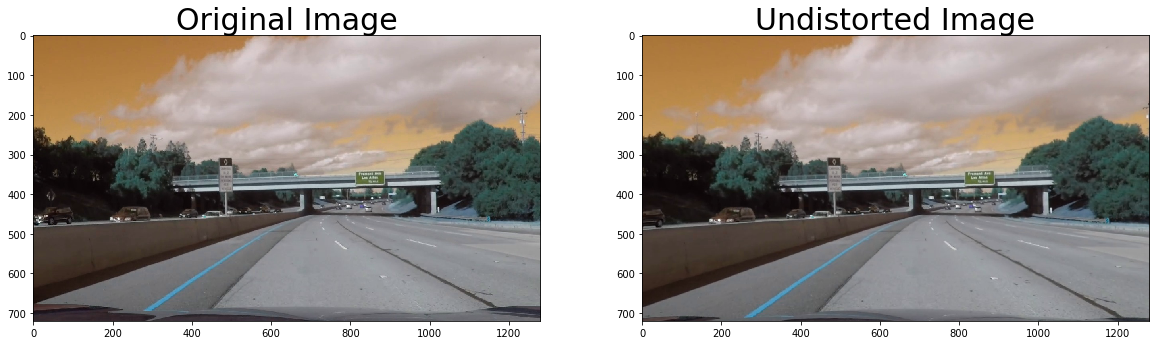

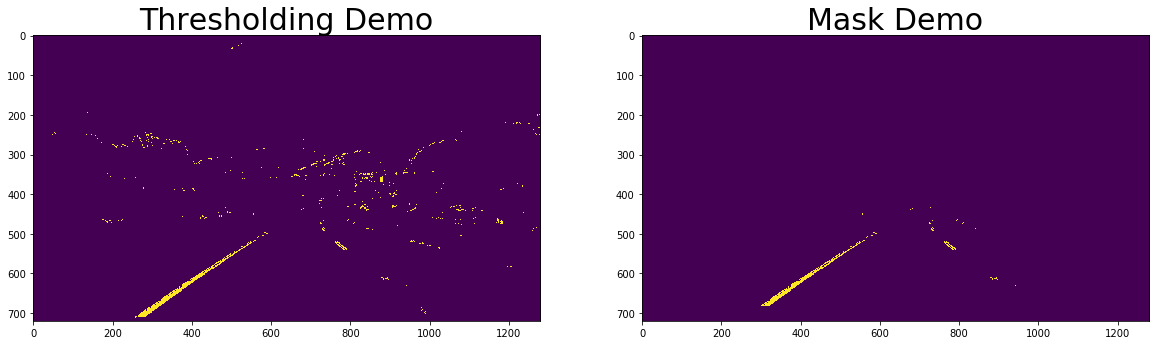

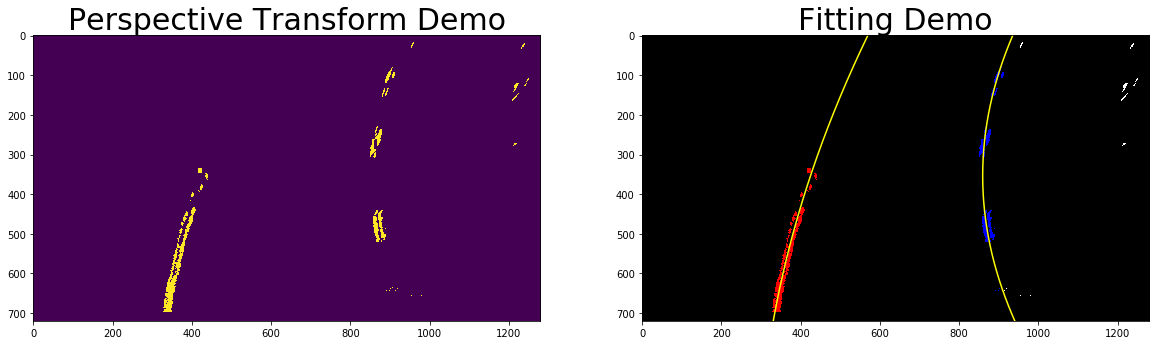

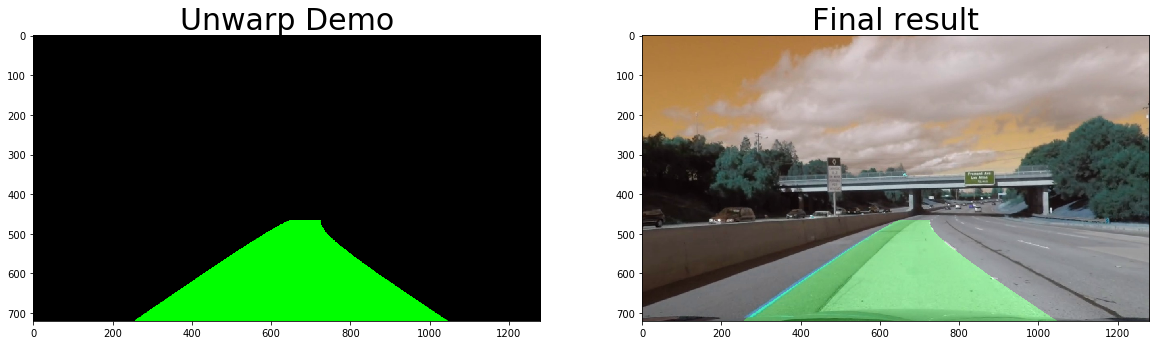

In [17]:
#############################
## Demostrate the pipeline ##
#############################
# load test image
demo = cv2.imread('test_images/test12.jpg')
rLane = Line()
lLane = Line()

# Undistort image and show result
undist_demo = cv2.undistort(np.copy(demo), mtx, dist)
image_test = cv2.cvtColor(np.copy(demo), cv2.COLOR_RGB2BGR)
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(demo)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_demo)
ax2.set_title('Undistorted Image', fontsize=30)

# Perform thresholding and masking
thres_demo = thresholding(np.copy(undist_demo))

# Perform masking
mask_out = np.zeros_like(thres_demo)  
mask_in = np.ones_like(thres_demo)  
out_color = 1 
in_color = 0
vertices_out = np.array([[(150,680),
                          (550, 430), 
                          (740, 430), 
                          (1180,680)]], dtype=np.int32)

vertices_in = np.array([[(390, 680),
                         (660, 500), 
                         (670, 500), 
                         (950, 680)]], dtype=np.int32)    

cv2.fillPoly(mask_out, vertices_out, out_color)
cv2.fillPoly(mask_in, vertices_in, in_color)

masked_demo = cv2.bitwise_and(thres_demo, mask_out)
masked_demo = cv2.bitwise_and(masked_demo, mask_in)
f2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(thres_demo)
ax1.set_title('Thresholding Demo', fontsize=30)
ax2.imshow(masked_demo)
ax2.set_title('Mask Demo', fontsize=30)

# Perform perspective transform
src = np.float32([[560, 485],
                  [770, 485],
                  [1100, 700],
                  [240, 700]])
dst = np.float32([[300, 250],
                  [1000, 250],
                  [1000, 700],
                  [300, 700]])
img_warp_demo, Minv = img_warp(np.copy(masked_demo), mtx, dist, src, dst)

# Perform sliding window search and fit the lanes
sws_demo, left_fitx, right_fitx, ploty = sws2(np.copy(img_warp_demo), rLane, lLane)
warped = masked_demo
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp_demo = np.dstack((warp_zero, warp_zero, warp_zero))
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(color_warp_demo, np.int_([pts]), (0,255, 0))
f3, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_warp_demo)
ax1.set_title('Perspective Transform Demo', fontsize=30)
ax2.imshow(sws_demo)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Fitting Demo', fontsize=30)

newwarp_demo = cv2.warpPerspective(np.copy(color_warp_demo), Minv, (demo.shape[1], demo.shape[0]))

# Combine the result with the original image
final_result = cv2.addWeighted(undist_demo, 1, newwarp_demo, 0.3, 0)
f5, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(newwarp_demo)
ax1.set_title('Unwarp Demo', fontsize=30)
ax2.imshow(final_result)
ax2.set_title('Final result', fontsize=30)

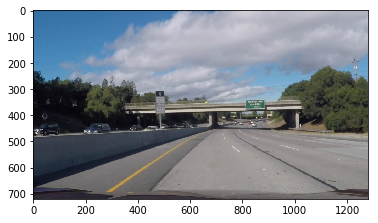

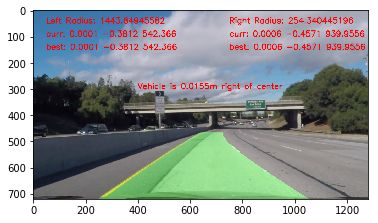

In [18]:
##############################
## Test functions and debug ##
##############################
image_test = mpimg.imread('test_images/test12.jpg')
rLane = Line()
lLane = Line()
plt.figure()
plt.imshow(image_test)
rLane = Line()
lLane = Line()
result1 = process_image(image_test, rLane, lLane, debug=0)
plt.figure()
plt.imshow(result1)


In [19]:
cv2.imwrite('./Testout/final_pipeline.jpg', result1)

True

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

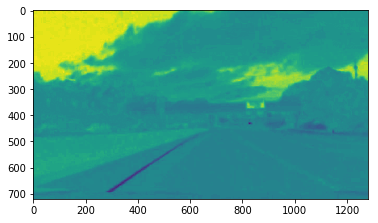

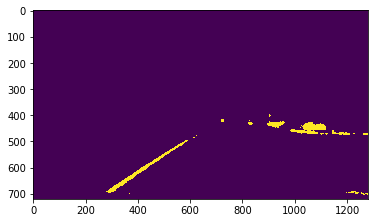

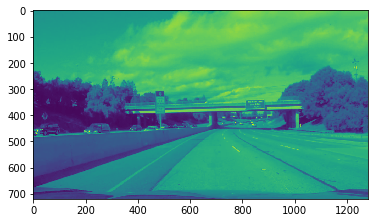

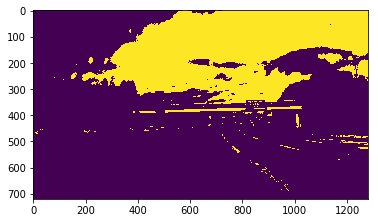

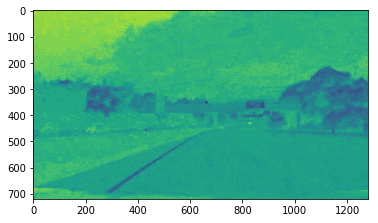

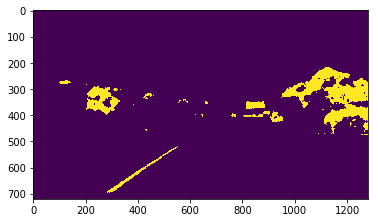

In [20]:
###########################
## Test LAB thresholding ##
###########################
image_test = mpimg.imread('test_images/test12.jpg')
LAB = cv2.cvtColor(np.copy(image_test), cv2.COLOR_BGR2LAB)
plt.figure()
plt.imshow(LAB[:,:,2])
LAB2 = LAB[:,:,2]
out2 = np.zeros_like(LAB2)
out2[(LAB2>=0) & (LAB2<=120)] = 1
plt.figure()
plt.imshow(out2)
LAB0 = LAB[:,:,0]
plt.figure()
plt.imshow(LAB0)
out0 = np.zeros_like(LAB0)
out0[(LAB0>=170) & (LAB0<=240)] = 1
plt.figure()
plt.imshow(out0)

LAB1 = LAB[:,:,1]
plt.figure()
plt.imshow(LAB1)
out1 = np.zeros_like(LAB1)
out1[(LAB1>=0) & (LAB1<=120)] = 1
plt.figure()
plt.imshow(out1)
out1

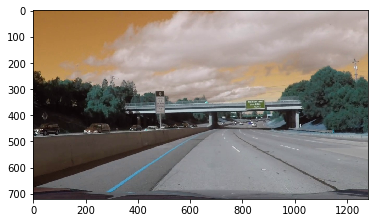

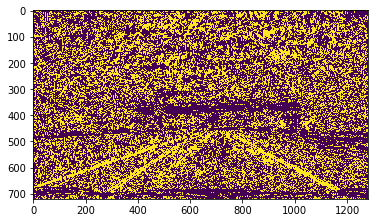

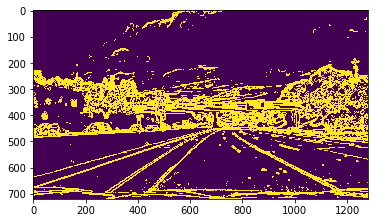

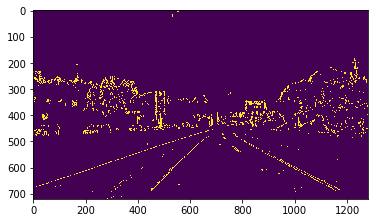

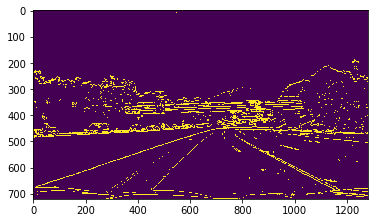

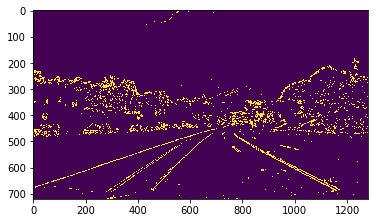

In [21]:
################################
## Test gradient thresholding ##
################################
image_test = mpimg.imread('test_images/test12.jpg')
image_test = cv2.cvtColor(image_test, cv2.COLOR_RGB2BGR)

grad = combined_grad_thres(image_test, 
                           dir_thres=(0.8,1.2), 
                           mag_thres=(20,100), 
                           gx_thres=(10,120), 
                           gy_thres=(10,120))

dir_binary = dir_threshold(image_test, sobel_kernel=15, thresh=(0.7,1.3))
mag_binary = mag_thresh(image_test, sobel_kernel=9, mag_thresh=(10,120))
gradx = abs_sobel_thresh(image_test, orient='x', sobel_kernel=3, mag_thresh=(20,120))
grady = abs_sobel_thresh(image_test, orient='y', sobel_kernel=3, mag_thresh=(20,120))
combined = np.zeros_like(dir_binary)
combined[((mag_binary == 1) & (dir_binary == 1))] = 1

plt.figure()
plt.imshow(image_test)
plt.figure()
plt.imshow(dir_binary)
plt.figure()
plt.imshow(mag_binary)
plt.figure()
plt.imshow(gradx)
plt.figure()
plt.imshow(grady)
plt.figure()
plt.imshow(grad)

In [22]:
#############################
## Generate new test image ##
#############################

# count = 0
# vidcap = cv2.VideoCapture('challenge_video.mp4')
# success = True
# while (count < 150):
#     success,image = vidcap.read()
#     count += 1
# print(count)
# plt.imshow(image)
# cv2.imwrite('./test_images/test15.jpg',image)

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
project_output = 'Testout/project.mp4'
challenge_output = 'Testout/challenge.mp4'
harder_challenge_output = 'Testout/hard_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
clip2 = VideoFileClip("challenge_video.mp4")
clip3 = VideoFileClip("harder_challenge_video.mp4")


In [25]:
rLane1 = Line()
lLane1 = Line()
def process_image1(image):
    return process_image(image, rLane=rLane1, lLane=lLane1, debug=0)

white_clip = clip1.fl_image(process_image1) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video Testout/project.mp4
[MoviePy] Writing video Testout/project.mp4


100%|█████████▉| 1260/1261 [08:22<00:00,  2.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Testout/project.mp4 

CPU times: user 7min 36s, sys: 1min 44s, total: 9min 20s
Wall time: 8min 24s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [27]:
rLane2 = Line()
lLane2 = Line()
def process_image2(image, rLane=rLane2, lLane=lLane2, debug=0):
    return process_image(image, rLane=rLane2, lLane=lLane2, debug=0)

challenge_clip = clip2.fl_image(process_image2) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video Testout/challenge.mp4
[MoviePy] Writing video Testout/challenge.mp4


100%|██████████| 485/485 [03:50<00:00,  2.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Testout/challenge.mp4 

CPU times: user 2min 57s, sys: 40.6 s, total: 3min 38s
Wall time: 3min 52s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
###############
## For debug ##
###############

# rLane2.temp[120:180]

In [ ]:
# rLane3 = Line()
# lLane3 = Line()
# print(rLane.best_fit)
# harder_challenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
# %time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

In [ ]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(harder_challenge_output))